# MedSAM2 Inference for SpineMetsCT Dataset

This notebook adapts the MedSAM2 inference process to work with the SpineMetsCT dataset located in the processed data directory at `/tmp2/b10902078/MEDSAM/processed_data/SpineMetsCT_npz/`. The dataset is organized into train/ and val/ directories, containing NPZ files with image and ground truth segmentation masks.

The NPZ files have the following structure:
- `imgs`: 3D volume with shape (slices, 512, 512)
- `gts`: Ground truth segmentation masks with the same shape

This notebook will demonstrate how to:
1. Load the SpineMetsCT dataset NPZ files
2. Run MedSAM2 inference on the dataset
3. Visualize and save the results
4. Evaluate performance metrics

In [2]:
# Import necessary libraries
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from PIL import Image
from skimage import measure, morphology

# Add MedSAM2 to Python path if not already there
if "MedSAM2" not in sys.path:
    sys.path.append("MedSAM2")

# Import MedSAM2 modules
from sam2.build_sam import build_sam2, build_sam2_video_predictor_npz
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Ensure reproducibility
torch.set_float32_matmul_precision('high')
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)

In [3]:
# Helper functions

def load_npz_data(npz_path):
    """Load data from an NPZ file."""
    data = np.load(npz_path)
    image = data['imgs']  # 3D volume
    gt_mask = data['gts'] if 'gts' in data else None  # Ground truth mask
    return image, gt_mask

def getLargestCC(segmentation):
    """Get the largest connected component of a segmentation mask."""
    labels = measure.label(segmentation)
    if np.max(labels) == 0:
        return segmentation
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def convert_to_rgb(image):
    """Convert a grayscale image to RGB format expected by MedSAM2."""
    # Normalize to 0-255 range if not already
    if image.max() > 1.0:
        image_norm = (image - image.min()) / (image.max() - image.min()) * 255.0
    else:
        image_norm = image * 255.0
    
    # Convert to uint8 for PIL
    image_uint8 = image_norm.astype(np.uint8)
    
    # Convert to RGB using PIL
    pil_image = Image.fromarray(image_uint8)
    rgb_image = pil_image.convert('RGB')
    
    # Convert back to numpy array (channels first format)
    rgb_array = np.array(rgb_image)
    rgb_array = np.transpose(rgb_array, (2, 0, 1)).astype(np.float32)
    
    # Normalize to 0-1 range for the model
    rgb_array = rgb_array / 255.0
    
    return rgb_array

def resize_grayscale_to_rgb_and_resize(array, image_size=512):
    """
    Resize a 3D grayscale NumPy array to an RGB image.
    
    Parameters:
        array (np.ndarray): Input array of shape (d, h, w).
        image_size (int): Desired size for the width and height.
    
    Returns:
        np.ndarray: Resized array of shape (d, 3, image_size, image_size).
    """
    d, h, w = array.shape
    resized_array = np.zeros((d, 3, image_size, image_size))
    
    for i in range(d):
        img_pil = Image.fromarray(array[i].astype(np.uint8))
        img_rgb = img_pil.convert("RGB")
        if h != image_size or w != image_size:
            img_resized = img_rgb.resize((image_size, image_size))
        else:
            img_resized = img_rgb
        img_array = np.array(img_resized).transpose(2, 0, 1)  # (3, image_size, image_size)
        resized_array[i] = img_array
    
    return resized_array

def show_mask(mask, ax, mask_color=None, alpha=0.5):
    """
    Show mask on the image.

    Parameters
    ----------
    mask : numpy.ndarray
        mask of the image
    ax : matplotlib.axes.Axes
        axes to plot the mask
    mask_color : numpy.ndarray
        color of the mask
    alpha : float
        transparency of the mask
    """
    if mask_color is not None:
        color = np.concatenate([mask_color, np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax, edgecolor='blue'):
    """
    Show bounding box on the image.

    Parameters
    ----------
    box : numpy.ndarray
        bounding box coordinates in the original image
    ax : matplotlib.axes.Axes
        axes to plot the bounding box
    edgecolor : str
        color of the bounding box
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0,0,0,0), lw=2))     

def calculate_dice(pred_mask, gt_mask):
    """Calculate Dice coefficient between prediction and ground truth."""
    intersection = (pred_mask * gt_mask).sum()
    return (2. * intersection) / (pred_mask.sum() + gt_mask.sum() + 1e-8)

def generate_bbox_from_mask(mask):
    """Generate a bounding box from a binary mask."""
    # Find indices of non-zero elements
    if np.sum(mask) == 0:
        # Return an empty box if the mask is empty
        return np.array([0, 0, 1, 1])
        
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    # Add some padding
    pad = 5
    x_min = max(0, x_min - pad)
    y_min = max(0, y_min - pad)
    x_max = min(mask.shape[1] - 1, x_max + pad)
    y_max = min(mask.shape[0] - 1, y_max + pad)
    
    return np.array([x_min, y_min, x_max, y_max])

## Set up the model and configuration

Here we configure the paths to the dataset and the MedSAM2 model checkpoint.

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Path to dataset
dataset_dir = "/tmp2/b10902078/MEDSAM/processed_data/SpineMetsCT_npz"
val_dir = os.path.join(dataset_dir, "val")
train_dir = os.path.join(dataset_dir, "train")

# Get list of NPZ files
val_files = sorted(glob.glob(os.path.join(val_dir, "*.npz")))
train_files = sorted(glob.glob(os.path.join(train_dir, "*.npz")))

print(f"Found {len(train_files)} training files")
print(f"Found {len(val_files)} validation files")

# Load MedSAM2 model
print("Loading MedSAM2 model...")
# sam_checkpoint = "MedSAM2/exp_log/single_gpu/checkpoints/checkpoint.pt"
sam_checkpoint = "MedSAM2/checkpoints/MedSAM2_2411.pt"  # Change this if you have a different checkpoint
model_cfg = "configs/sam2.1_hiera_t512.yaml"  # Adjust path if needed

# Create output directories
output_dir = "spine_mets_results"
os.makedirs(output_dir, exist_ok=True)

Using device: cuda
Found 7000 training files
Found 1704 validation files
Loading MedSAM2 model...


## Approach 1: Single Image Prediction

First, we'll use the standard image predictor to process individual slices from our dataset.

  0%|          | 0/1704 [00:00<?, ?it/s]

Slice 0 - Dice score: 0.0000


  0%|          | 0/1704 [00:01<?, ?it/s]

Slice 2 - Dice score: 0.0000


KeyboardInterrupt: 

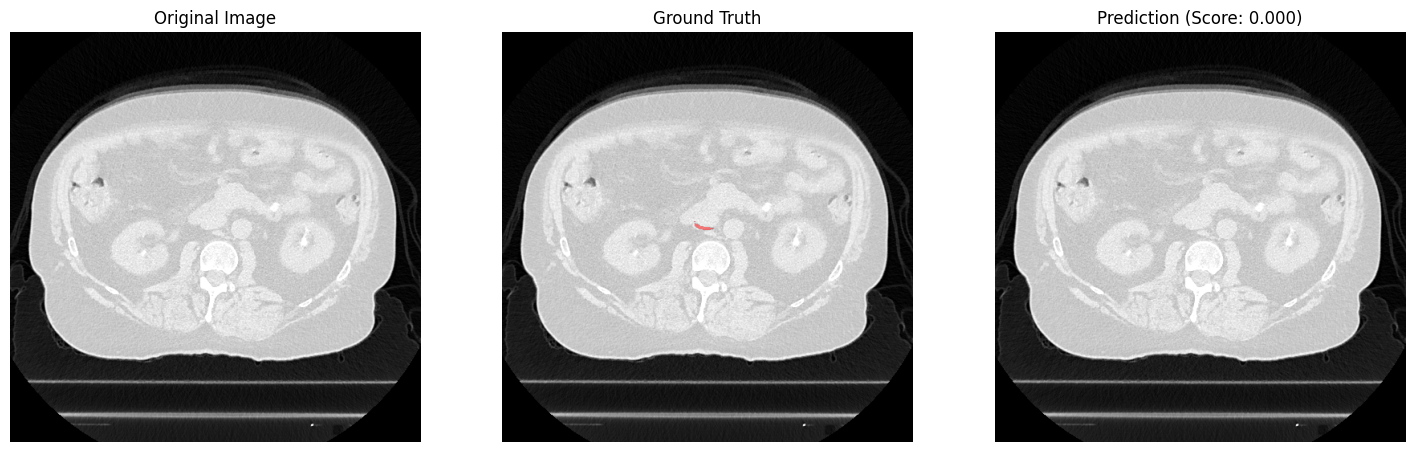

In [31]:
# Build model for single image prediction
sam = build_sam2(
    config_file=model_cfg, 
    ckpt_path=sam_checkpoint,
    device=device
)

# Create predictor
image_predictor = SAM2ImagePredictor(sam)

# Process a few validation samples
num_samples = 3
max_slices_per_sample = 4

# Metrics dictionary
metrics_single = {'dice': []}

for i, npz_path in enumerate(tqdm(val_files)):
    filename = os.path.basename(npz_path)
    # print(f"\nProcessing {filename} with single image prediction...")
    
    # Load image and ground truth
    image_3d, gt_mask = load_npz_data(npz_path)
    # print(f"Loaded data shapes - Image: {image_3d.shape}, Mask: {gt_mask.shape}")
    
    # Process selected slices
    total_slices = image_3d.shape[0]
    slice_indices = [
        0,  # First slice
        total_slices // 3,  # One-third through the volume
        total_slices // 2,  # Middle slice
        total_slices - 1,  # Last slice
    ][:max_slices_per_sample]
    
    for slice_idx in slice_indices:
        # Get the image and ground truth for this slice
        image = image_3d[slice_idx]
        gt_slice = gt_mask[slice_idx] if gt_mask is not None else None
        
        # Convert to RGB format using PIL
        # Normalize to 0-255 range if not already
        if image.max() > 1.0:
            image_norm = (image - image.min()) / (image.max() - image.min()) * 255.0
        else:
            image_norm = image * 255.0
        
        # Convert to uint8 for PIL
        image_uint8 = image_norm.astype(np.uint8)
        
        # Create PIL Image and convert to RGB (predictor expects RGB format)
        pil_image = Image.fromarray(image_uint8).convert('RGB')
        
        # Set image for predictor
        image_predictor.set_image(pil_image)
        
        # Get automatic mask prediction (no prompt needed)
        masks, scores, _ = image_predictor.predict()
        
        # Visualize results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Ground truth
        if gt_slice is not None:
            axes[1].imshow(image, cmap='gray')
            show_mask(gt_slice, ax=axes[1], mask_color=np.array([1.0, 0, 0]))
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')
        else:
            axes[1].set_visible(False)
        
        # Prediction
        if len(masks) > 0:
            mask = masks[0]
            axes[2].imshow(image, cmap='gray')
            show_mask(mask, ax=axes[2], mask_color=np.array([0, 0, 1.0]))
            axes[2].set_title(f"Prediction (Score: {scores[0]:.3f})")
            axes[2].axis('off')
            
            # Calculate metrics
            if gt_slice is not None:
                dice = calculate_dice(mask, gt_slice)
                metrics_single['dice'].append(dice)
                print(f"Slice {slice_idx} - Dice score: {dice:.4f}")
        else:
            axes[2].imshow(image, cmap='gray')
            axes[2].set_title("No prediction")
            axes[2].axis('off')
        
        # Save figure
        plt.tight_layout()
        output_filename = f"{os.path.splitext(filename)[0]}_slice{slice_idx}_single_image.png"
        plt.savefig(os.path.join(output_dir, output_filename), dpi=150)
        plt.close(fig)

## Approach 2: Video Prediction (3D Volume)

Now we'll use the video predictor to process the entire 3D volume as a sequence, which should better handle the 3D nature of the data.

In [5]:
# Build video predictor for 3D volumes
video_predictor = build_sam2_video_predictor_npz(model_cfg, sam_checkpoint)

# Metrics dictionary for video approach
metrics_video = {'dice': []}

: 

In [ ]:
for i, npz_path in enumerate(tqdm(val_files[:num_samples])):
    filename = os.path.basename(npz_path)
    print(f"\nProcessing {filename} with video prediction...")
    
    # Load image and ground truth
    image_3d, gt_mask = load_npz_data(npz_path)
    print(f"Loaded data shapes - Image: {image_3d.shape}, Mask: {gt_mask.shape}")
    
    # Check and normalize image values if needed
    if image_3d.max() > 255 or image_3d.min() < 0:
        print(f"Normalizing image from range [{image_3d.min()}, {image_3d.max()}] to [0, 255]")
        image_3d = np.clip((image_3d - image_3d.min()) / (image_3d.max() - image_3d.min()) * 255.0, 0, 255).astype(np.uint8)
    elif image_3d.max() <= 1.0:
        print(f"Normalizing image from range [{image_3d.min()}, {image_3d.max()}] to [0, 255]")
        image_3d = (image_3d * 255.0).astype(np.uint8)
    
    # Convert to RGB format and resize if needed
    video_height, video_width = image_3d.shape[1], image_3d.shape[2]
    img_resized = resize_grayscale_to_rgb_and_resize(image_3d, 512)
    img_resized = img_resized / 255.0
    img_resized = torch.from_numpy(img_resized).cuda()
    
    # Normalize with ImageNet stats
    img_mean = (0.485, 0.456, 0.406)
    img_std = (0.229, 0.224, 0.225)
    img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None].cuda()
    img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None].cuda()
    img_resized -= img_mean
    img_resized /= img_std
    
    # Initialize 3D segmentation volume
    segs_3D = np.zeros(image_3d.shape, dtype=np.uint8)
    
    # Select a key slice for initial segmentation (middle of the volume)
    key_slice_idx = image_3d.shape[0] // 2
    
    # Get ground truth for key slice to generate a box prompt
    gt_key_slice = gt_mask[key_slice_idx] if gt_mask is not None else None
    
    # If we have ground truth, use it to generate a bounding box
    if gt_key_slice is not None and np.sum(gt_key_slice) > 0:
        bbox = generate_bbox_from_mask(gt_key_slice)
    else:
        # If no ground truth, use a default box covering most of the image
        h, w = image_3d.shape[1], image_3d.shape[2]
        margin = min(h, w) // 4
        bbox = np.array([margin, margin, w - margin, h - margin])
    
    # Initialize inference state
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        inference_state = video_predictor.init_state(img_resized, video_height, video_width)
        
        # Add bounding box prompt on the key slice
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=key_slice_idx,
            obj_id=1,
            box=bbox,
        )
        
        # Propagate forward
        for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state):
            segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
        video_predictor.reset_state(inference_state)
        
        # Add the box again for backward propagation
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=key_slice_idx,
            obj_id=1,
            box=bbox,
        )
        
        # Propagate backward
        for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state, reverse=True):
            segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
        video_predictor.reset_state(inference_state)
    
    # Post-process the segmentation to get the largest connected component
    if np.max(segs_3D) > 0:
        segs_3D = getLargestCC(segs_3D)
        segs_3D = np.uint8(segs_3D)
    
    # Visualize and compare the same slices as in the single image approach
    for slice_idx in slice_indices:
        # Get images and masks
        image = image_3d[slice_idx]
        gt_slice = gt_mask[slice_idx] if gt_mask is not None else None
        pred_slice = segs_3D[slice_idx]
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Ground truth
        if gt_slice is not None:
            axes[1].imshow(image, cmap='gray')
            show_mask(gt_slice, ax=axes[1], mask_color=np.array([1.0, 0, 0]))
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')
        else:
            axes[1].set_visible(False)
        
        # Video prediction
        axes[2].imshow(image, cmap='gray')
        show_mask(pred_slice, ax=axes[2], mask_color=np.array([0, 0, 1.0]))
        axes[2].set_title("Video Prediction")
        axes[2].axis('off')
        
        # Calculate metrics
        if gt_slice is not None:
            dice = calculate_dice(pred_slice, gt_slice)
            metrics_video['dice'].append(dice)
            print(f"Slice {slice_idx} - Dice score: {dice:.4f}")
        
        # Save figure
        plt.tight_layout()
        output_filename = f"{os.path.splitext(filename)[0]}_slice{slice_idx}_video.png"
        plt.savefig(os.path.join(output_dir, output_filename), dpi=150)
        plt.close(fig)
    
    # Save the 3D segmentation masks for future use
    if not os.path.exists(os.path.join(output_dir, "segmentations")):
        os.makedirs(os.path.join(output_dir, "segmentations"))
    np.savez_compressed(
        os.path.join(output_dir, "segmentations", f"{os.path.splitext(filename)[0]}_segs.npz"),
        imgs=image_3d,
        gts=gt_mask,
        preds=segs_3D
    )



  0%|          | 0/3 [00:00<?, ?it/s]


Processing 12459_12-03-2011-SpineSPINEBONESBRT Adult-86764_5.000000-SKINTOSKINSIM0.5MM12459a iMAR-11927_300.000000-Spine Segmentation-88451_0.npz with video prediction...
Loaded data shapes - Image: (8, 512, 512), Mask: (8, 512, 512)


Slice 0 - Dice score: 0.0000
Slice 2 - Dice score: 0.0000
Slice 4 - Dice score: 0.1714
Slice 7 - Dice score: 0.1661


 33%|███▎      | 1/3 [00:06<00:13,  6.70s/it]


Processing 12459_12-03-2011-SpineSPINEBONESBRT Adult-86764_5.000000-SKINTOSKINSIM0.5MM12459a iMAR-11927_300.000000-Spine Segmentation-88451_100.npz with video prediction...
Loaded data shapes - Image: (8, 512, 512), Mask: (8, 512, 512)
Slice 0 - Dice score: 0.6793
Slice 2 - Dice score: 0.6406
Slice 4 - Dice score: 0.5690
Slice 7 - Dice score: 0.5709


 67%|██████▋   | 2/3 [00:13<00:06,  6.62s/it]


Processing 12459_12-03-2011-SpineSPINEBONESBRT Adult-86764_5.000000-SKINTOSKINSIM0.5MM12459a iMAR-11927_300.000000-Spine Segmentation-88451_104.npz with video prediction...
Loaded data shapes - Image: (8, 512, 512), Mask: (8, 512, 512)
Slice 0 - Dice score: 0.6039
Slice 2 - Dice score: 0.5698
Slice 4 - Dice score: 0.5352
Slice 7 - Dice score: 0.4486


100%|██████████| 3/3 [00:19<00:00,  6.58s/it]


## Compare Results and Metrics

Let's compare the performance of both approaches.


===== Performance Metrics =====

Single Image Approach:
Average Dice Score: 0.0000 ± 0.0000
Min Dice: 0.0000, Max Dice: 0.0000

Video Approach:
Average Dice Score: 0.4129 ± 0.2432
Min Dice: 0.0000, Max Dice: 0.6793


/tmp/ipykernel_4167928/3899020327.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([metrics_single['dice'], metrics_video['dice']], labels=['Single Image', 'Video'])


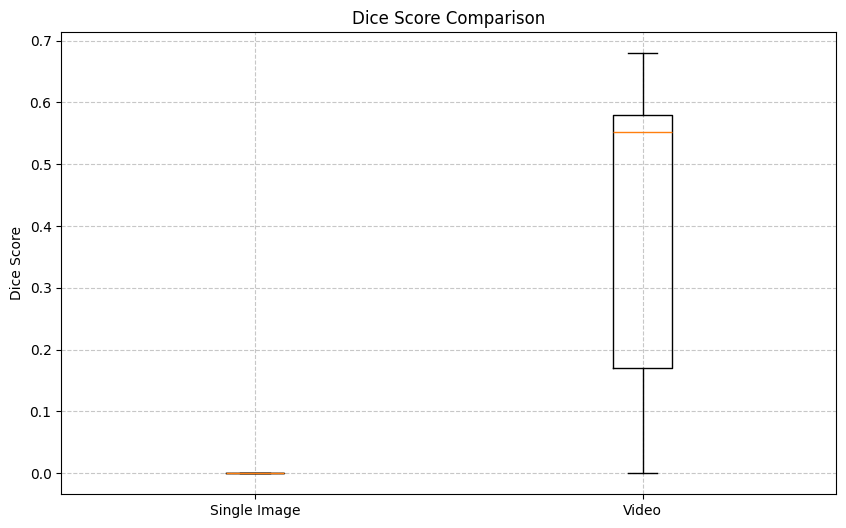

In [10]:
# Print and compare metrics
print("\n===== Performance Metrics =====")

print("\nSingle Image Approach:")
if metrics_single['dice']:
    avg_dice = np.mean(metrics_single['dice'])
    std_dice = np.std(metrics_single['dice'])
    min_dice = np.min(metrics_single['dice'])
    max_dice = np.max(metrics_single['dice'])
    print(f"Average Dice Score: {avg_dice:.4f} ± {std_dice:.4f}")
    print(f"Min Dice: {min_dice:.4f}, Max Dice: {max_dice:.4f}")
else:
    print("No metrics collected for single image approach")

print("\nVideo Approach:")
if metrics_video['dice']:
    avg_dice = np.mean(metrics_video['dice'])
    std_dice = np.std(metrics_video['dice'])
    min_dice = np.min(metrics_video['dice'])
    max_dice = np.max(metrics_video['dice'])
    print(f"Average Dice Score: {avg_dice:.4f} ± {std_dice:.4f}")
    print(f"Min Dice: {min_dice:.4f}, Max Dice: {max_dice:.4f}")
else:
    print("No metrics collected for video approach")

# Create a combined plot if both approaches have metrics
if metrics_single['dice'] and metrics_video['dice']:
    plt.figure(figsize=(10, 6))
    plt.boxplot([metrics_single['dice'], metrics_video['dice']], labels=['Single Image', 'Video'])
    plt.title('Dice Score Comparison')
    plt.ylabel('Dice Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    plt.savefig(os.path.join(output_dir, "dice_comparison.png"), dpi=150)
    plt.close()

## Process Full Validation Set

Use this cell if you want to process the entire validation set.

In [33]:
# Uncomment this cell to process the entire validation set

# Process all validation files
all_dice_scores = []

for idx, npz_path in enumerate(tqdm(val_files)):
    filename = os.path.basename(npz_path)
    # print(f"\nProcessing {filename}...")
    
    # Load image and ground truth
    image_3d, gt_mask = load_npz_data(npz_path)
    
    # Check and normalize image values if needed
    if image_3d.max() > 255 or image_3d.min() < 0:
        image_3d = np.clip((image_3d - image_3d.min()) / (image_3d.max() - image_3d.min()) * 255.0, 0, 255).astype(np.uint8)
    elif image_3d.max() <= 1.0:
        image_3d = (image_3d * 255.0).astype(np.uint8)
    
    # Process with video predictor
    # Convert to RGB format and resize if needed
    video_height, video_width = image_3d.shape[1], image_3d.shape[2]
    img_resized = resize_grayscale_to_rgb_and_resize(image_3d, 512)
    img_resized = img_resized / 255.0
    img_resized = torch.from_numpy(img_resized).cuda()
    
    # Normalize with ImageNet stats
    img_mean = (0.485, 0.456, 0.406)
    img_std = (0.229, 0.224, 0.225)
    img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None].cuda()
    img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None].cuda()
    img_resized -= img_mean
    img_resized /= img_std
    
    # Initialize 3D segmentation volume
    segs_3D = np.zeros(image_3d.shape, dtype=np.uint8)
    
    # Select a key slice for initial segmentation (middle of the volume)
    key_slice_idx = image_3d.shape[0] // 2
    
    # Get ground truth for key slice to generate a box prompt
    gt_key_slice = gt_mask[key_slice_idx] if gt_mask is not None else None
    
    # If we have ground truth, use it to generate a bounding box
    if gt_key_slice is not None and np.sum(gt_key_slice) > 0:
        bbox = generate_bbox_from_mask(gt_key_slice)
    else:
        # If no ground truth, use a default box covering most of the image
        h, w = image_3d.shape[1], image_3d.shape[2]
        margin = min(h, w) // 4
        bbox = np.array([margin, margin, w - margin, h - margin])
    
    # Initialize inference state
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        inference_state = video_predictor.init_state(img_resized, video_height, video_width)
        
        # Add bounding box prompt on the key slice
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=key_slice_idx,
            obj_id=1,
            box=bbox,
        )
        
        # Propagate forward
        for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state):
            segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
        video_predictor.reset_state(inference_state)
        
        # Add the box again for backward propagation
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=key_slice_idx,
            obj_id=1,
            box=bbox,
        )
        
        # Propagate backward
        for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state, reverse=True):
            segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
        video_predictor.reset_state(inference_state)
    
    # Post-process the segmentation to get the largest connected component
    if np.max(segs_3D) > 0:
        segs_3D = getLargestCC(segs_3D)
        segs_3D = np.uint8(segs_3D)
    
    # Calculate overall Dice score for the 3D volume
    if gt_mask is not None:
        volume_dice = calculate_dice(segs_3D, gt_mask)
        all_dice_scores.append(volume_dice)
        # print(f"Volume Dice score: {volume_dice:.4f}")
    
    # Save results
    if not os.path.exists(os.path.join(output_dir, "segmentations")):
        os.makedirs(os.path.join(output_dir, "segmentations"))
    if idx < 10:
        np.savez_compressed(
            os.path.join(output_dir, "segmentations", f"{os.path.splitext(filename)[0]}_segs.npz"),
            imgs=image_3d,
            gts=gt_mask,
            preds=segs_3D
        )

# Print overall results
if all_dice_scores:
    avg_dice = np.mean(all_dice_scores)
    std_dice = np.std(all_dice_scores)
    print(f"\nOverall Average Dice Score: {avg_dice:.4f} ± {std_dice:.4f}")
    print(f"Min: {np.min(all_dice_scores):.4f}, Max: {np.max(all_dice_scores):.4f}")

# medsam2_latest: dice score 0.4682 ± 0.2048
# medsam2_mycheckpoint: Dice Score: 0.4536 ± 0.2059
# medsam2_2411: Dice Score: 0.3427 ± 0.1905

100%|██████████| 1704/1704 [09:02<00:00,  3.14it/s]


Overall Average Dice Score: 0.3427 ± 0.1905
Min: 0.0000, Max: 0.8109


## Conclusion

This notebook demonstrates how to adapt MedSAM2 for inference on the SpineMetsCT dataset. Two approaches were explored:

1. Single image prediction: Processing each slice independently
2. Video prediction: Processing the 3D volume as a sequence with propagation

The video prediction approach typically results in more consistent segmentations across slices, while the single image approach might be more accurate for individual slices but less consistent across the volume.

For future work, you could:
1. Fine-tune MedSAM2 on the SpineMetsCT training data
2. Experiment with different prompting strategies
3. Apply post-processing techniques to improve segmentation quality

## Visualize Saved Results

The notebook already saves individual slices during processing, but if you've already run the inference and want to visualize the results without rerunning the entire process, you can use this cell.

In [1]:
# Function to display saved results
def display_saved_results(results_dir, num_examples=3):
    """
    Display saved segmentation results from the output directory.
    
    Parameters:
    -----------
    results_dir : str
        Path to the directory containing saved results
    num_examples : int
        Number of examples to display
    """
    # Look for segmentation files in the segmentations subdirectory
    segmentation_dir = os.path.join(results_dir, "segmentations")
    
    if os.path.exists(segmentation_dir):
        # Load saved NPZ files with segmentations
        npz_files = sorted(glob.glob(os.path.join(segmentation_dir, "*.npz")))
        
        if npz_files:
            print(f"Found {len(npz_files)} segmentation files. Displaying {min(num_examples, len(npz_files))} examples.")
            
            for i, npz_path in enumerate(npz_files[::8][:num_examples]):
                data = np.load(npz_path)
                
                # Extract data
                imgs = data['imgs']
                gts = data['gts'] if 'gts' in data else None
                preds = data['preds'] if 'preds' in data else None
                
                if imgs is not None and preds is not None:
                    # Display 3D view with multiple slices
                    total_slices = imgs.shape[0]
                    slice_indices = [
                        0,  # First slice
                        total_slices // 3,  # One-third through the volume
                        total_slices // 2,  # Middle slice
                        total_slices - 1,  # Last slice
                    ]
                    
                    # Create a figure with rows for each slice and columns for original, GT, and prediction
                    fig, axes = plt.subplots(len(slice_indices), 3, figsize=(15, 4*len(slice_indices)))
                    fig.suptitle(f"Example {i+1}: {os.path.basename(npz_path)}", fontsize=16)
                    
                    # Set column titles
                    axes[0, 0].set_title("Original Image")
                    if gts is not None:
                        axes[0, 1].set_title("Ground Truth")
                    else:
                        axes[0, 1].set_title("No Ground Truth")
                    axes[0, 2].set_title("MedSAM2 Prediction")
                    
                    # Plot each slice
                    for row_idx, slice_idx in enumerate(slice_indices):
                        img = imgs[slice_idx]
                        
                        # Original image
                        axes[row_idx, 0].imshow(img, cmap='gray')
                        axes[row_idx, 0].set_ylabel(f"Slice {slice_idx}")
                        axes[row_idx, 0].axis('off')
                        
                        # Ground truth if available
                        axes[row_idx, 1].imshow(img, cmap='gray')
                        if gts is not None:
                            gt_slice = gts[slice_idx]
                            show_mask(gt_slice, ax=axes[row_idx, 1], mask_color=np.array([1.0, 0, 0]))
                        axes[row_idx, 1].axis('off')
                        
                        # Prediction
                        pred_slice = preds[slice_idx]
                        axes[row_idx, 2].imshow(img, cmap='gray')
                        show_mask(pred_slice, ax=axes[row_idx, 2], mask_color=np.array([0, 0, 1.0]))
                        
                        # Add Dice score if ground truth is available
                        if gts is not None:
                            dice = calculate_dice(pred_slice, gts[slice_idx])
                            axes[row_idx, 2].set_title(f"Prediction (Dice: {dice:.4f})")
                        
                        axes[row_idx, 2].axis('off')
                    
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.92)
                    plt.show()
                    
                else:
                    print(f"File {npz_path} doesn't contain expected data.")
                    
        else:
            print("No NPZ files found in the segmentations directory.")
    
    else:
        # Look for image files directly in the results directory
        image_files = sorted(glob.glob(os.path.join(results_dir, "*video.png")))
        
        if image_files:
            print(f"Found {len(image_files)} image files. Displaying {min(num_examples*4, len(image_files))} examples.")
            
            # Group files by their base name
            file_groups = {}
            for f in image_files:
                base_name = "_".join(os.path.basename(f).split("_")[:-2])  # Remove slice and method suffix
                if base_name not in file_groups:
                    file_groups[base_name] = []
                file_groups[base_name].append(f)
            
            # Display groups
            for i, (base_name, files) in enumerate(list(file_groups.items())[:num_examples]):
                # Get corresponding single image predictions for comparison
                single_image_files = [f.replace("_video.png", "_single_image.png") for f in files]
                
                # Create a figure with rows for each slice and columns for video and single image
                fig, axes = plt.subplots(len(files), 2, figsize=(12, 4*len(files)))
                fig.suptitle(f"Example {i+1}: {base_name}", fontsize=16)
                
                # Set column titles
                if len(files) > 1:
                    axes[0, 0].set_title("Video Prediction")
                    axes[0, 1].set_title("Single Image Prediction")
                else:
                    axes[0].set_title("Video Prediction")
                    axes[1].set_title("Single Image Prediction")
                
                # Plot each slice
                for row_idx, (video_file, single_file) in enumerate(zip(files, single_image_files)):
                    if os.path.exists(single_file):
                        # Load images
                        video_img = plt.imread(video_file)
                        single_img = plt.imread(single_file)
                        
                        # Plot images
                        if len(files) > 1:
                            axes[row_idx, 0].imshow(video_img)
                            axes[row_idx, 0].set_ylabel(f"Slice {row_idx}")
                            axes[row_idx, 0].axis('off')
                            
                            axes[row_idx, 1].imshow(single_img)
                            axes[row_idx, 1].axis('off')
                        else:
                            axes[0].imshow(video_img)
                            axes[0].axis('off')
                            
                            axes[1].imshow(single_img)
                            axes[1].axis('off')
                
                plt.tight_layout()
                plt.subplots_adjust(top=0.92)
                plt.show()
        
        else:
            print("No result images found in the output directory.")

# Visualize already processed results
display_saved_results(output_dir)

NameError: name 'output_dir' is not defined